In [1]:
import pandas
import seaborn
from matplotlib import pyplot

import swasputils

In [2]:
FILTERING_WORKFLOW = 17313
MAIN_WORKFLOW = 7534

In [3]:
all_classifications = swasputils.ZooniverseClassifications()

In [4]:
filtering_classifications = all_classifications.get_workflow(FILTERING_WORKFLOW)

In [5]:
filtering_classifications.decode_annotations()

In [6]:
value_counts = {}
for value in ('Real', 'Junk'):
    filtered_classifications = filtering_classifications.df[
        filtering_classifications.df['annotation_T0'] == value
    ]['created_at']
    filtered_classifications = filtered_classifications.value_counts()
    filtered_classifications.index = pandas.to_datetime(filtered_classifications.index)
    filtered_classifications.name = value
    value_counts[value] = filtered_classifications.resample('1D').count()
value_counts = pandas.DataFrame(value_counts)

<AxesSubplot:>

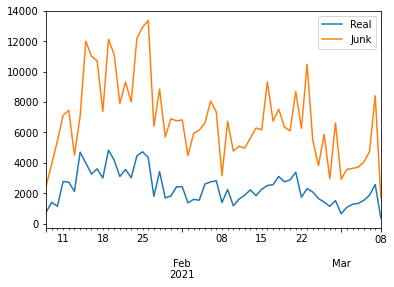

In [7]:
value_counts.plot()

<AxesSubplot:>

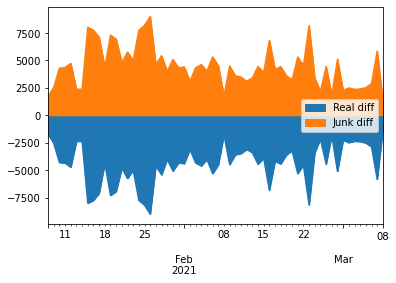

In [8]:
diff = value_counts['Real'] - value_counts['Junk']
value_counts['Real diff'] = diff
value_counts['Junk diff'] = -diff
value_counts[['Real diff', 'Junk diff']].plot.area()

<AxesSubplot:>

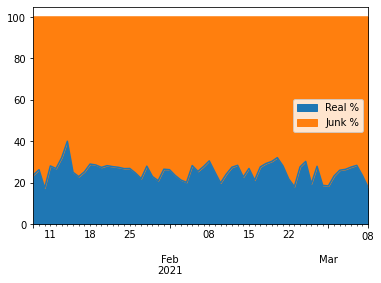

In [9]:
total = value_counts['Real'] + value_counts['Junk']
value_counts['Real %'] = value_counts['Real'] / total * 100
value_counts['Junk %'] = value_counts['Junk'] / total * 100
value_counts[['Real %', 'Junk %']].plot.area()

# Validation against main workflow

To do: This needs to count subjects as "real" in the filtering workflow if they have just one real classification.

In [10]:
filtering_majority = filtering_classifications.count_annotations().aggregate(
    lambda row: 'Real' if row['Real'] > 0 else 'Junk', 
    axis='columns',
)

In [11]:
main_classifications = all_classifications.get_workflow(MAIN_WORKFLOW)
main_classifications.df = main_classifications.df[main_classifications.df['subject_ids'].isin(filtering_majority.index)]
main_classifications.decode_annotations()

In [12]:
main_majority = main_classifications.count_annotations()
# Rearrange columns to match priority order for equal classification counts
# idxmax will pick the first label in this order if the counts are equal
main_majority = main_majority[['Junk', 'Pulsator', 'Rotator', 'EW type', 'EA/EB type', 'Unknown']]
main_majority = main_majority.idxmax(axis='columns')

In [13]:
majorities = pandas.DataFrame({'main': main_majority, 'filtering': filtering_majority})

<AxesSubplot:title={'center':'Majority Class in Main Workflow vs Filtering Workflow'}, xlabel='main', ylabel='filtering'>

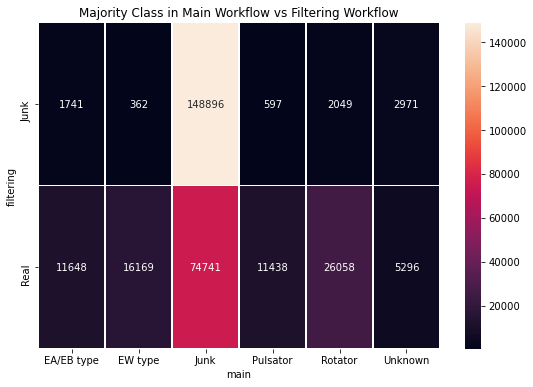

In [14]:
comparison_df = pandas.pivot_table(
    majorities.reset_index(),
    index='filtering',
    columns='main',
    values='subject_ids',
    aggfunc=lambda x: len(x.unique()),
)
f, ax = pyplot.subplots(figsize=(9, 6))
pyplot.title('Majority Class in Main Workflow vs Filtering Workflow')
seaborn.heatmap(comparison_df, annot=True, fmt=".0f", linewidths=.5, ax=ax)

<AxesSubplot:title={'center':'Majority Class in Main Workflow vs Filtering Workflow'}, xlabel='main', ylabel='filtering'>

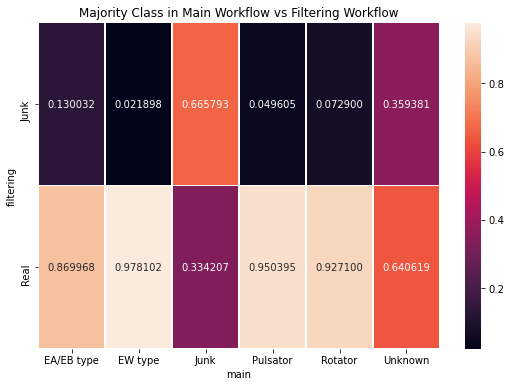

In [15]:
f, ax = pyplot.subplots(figsize=(9, 6))
pyplot.title('Majority Class in Main Workflow vs Filtering Workflow')
seaborn.heatmap(comparison_df/comparison_df.sum(), annot=True, fmt="f", linewidths=.5, ax=ax)

In [16]:
consolidated_comparison_df = pandas.DataFrame({
    'Junk': comparison_df['Junk'],
    'Real': comparison_df[[k for k in comparison_df.keys() if k != 'Junk']].sum(axis='columns'),
}).rename_axis('Main', axis='columns')

<AxesSubplot:title={'center':'Majority Class in Main Workflow vs Filtering Workflow'}, xlabel='Main', ylabel='filtering'>

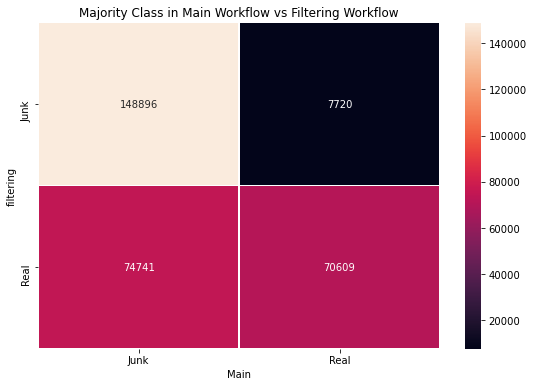

In [17]:
f, ax = pyplot.subplots(figsize=(9, 6))
pyplot.title('Majority Class in Main Workflow vs Filtering Workflow')
seaborn.heatmap(consolidated_comparison_df, annot=True, fmt=".0f", linewidths=.5, ax=ax)

<AxesSubplot:title={'center':'Majority Class in Main Workflow vs Filtering Workflow'}, xlabel='Main', ylabel='filtering'>

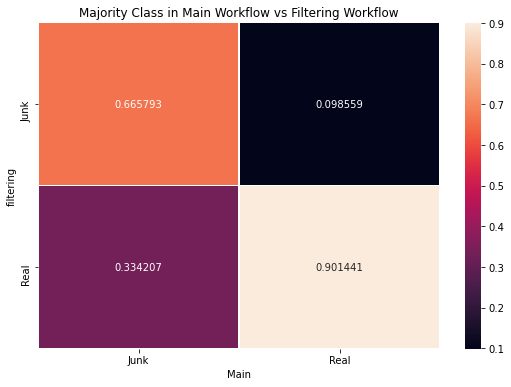

In [18]:
f, ax = pyplot.subplots(figsize=(9, 6))
pyplot.title('Majority Class in Main Workflow vs Filtering Workflow')
seaborn.heatmap(consolidated_comparison_df/consolidated_comparison_df.sum(), annot=True, fmt="f", linewidths=.5, ax=ax)

In [19]:
consolidated_comparison_df_junk_unknown_union = pandas.DataFrame({
    'Junk': comparison_df[['Junk', 'Unknown']].sum(axis='columns'),
    'Real': comparison_df[[k for k in comparison_df.keys() if k not in ('Junk', 'Unknown')]].sum(axis='columns'),
}).rename_axis('Main', axis='columns')

<AxesSubplot:title={'center':'Majority Class in Main Workflow vs Filtering Workflow'}, xlabel='Main', ylabel='filtering'>

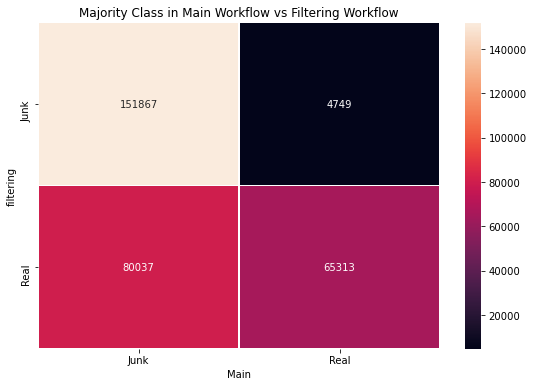

In [20]:
f, ax = pyplot.subplots(figsize=(9, 6))
pyplot.title('Majority Class in Main Workflow vs Filtering Workflow')
seaborn.heatmap(consolidated_comparison_df_junk_unknown_union, annot=True, fmt=".0f", linewidths=.5, ax=ax)

<AxesSubplot:title={'center':'Majority Class in Main Workflow vs Filtering Workflow'}, xlabel='Main', ylabel='filtering'>

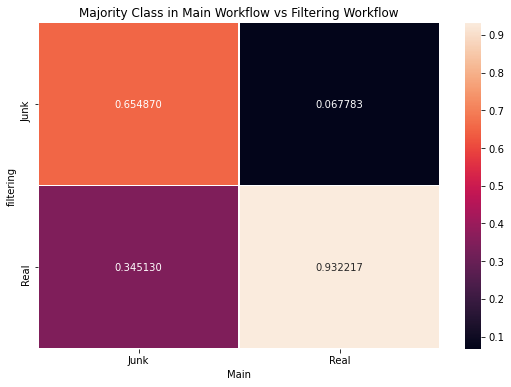

In [21]:
f, ax = pyplot.subplots(figsize=(9, 6))
pyplot.title('Majority Class in Main Workflow vs Filtering Workflow')
seaborn.heatmap(consolidated_comparison_df_junk_unknown_union/consolidated_comparison_df_junk_unknown_union.sum(), annot=True, fmt="f", linewidths=.5, ax=ax)